In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import glob
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc, os
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
#import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
physical_devices = tf.config.list_physical_devices()
print(physical_devices)

Version:  2.2.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


## 1. Loading data

In [46]:
with open('../outputs/augmented_data.cp', 'rb') as myfile:
    data = pickle.load(myfile)
cts = tf.cast(data['cts'], dtype=tf.float64)
lungs = tf.cast(data['lungs'], dtype=tf.double)
infects = tf.cast(data['infects'], dtype=tf.double)

img_size = cts.shape[1]
print(cts.shape, lungs.shape, infects.shape)

(4808, 128, 128, 1) (4808, 128, 128, 1) (4808, 128, 128, 1)


# 2. Loading Lung Segmentation Model

In [47]:
def lung_seg(input_shape, num_filters=[16,32,128]) :
    
    x_input = Input(input_shape)
    
    ###  LUNG SEGMENTATION
    x = Conv2D(num_filters[0], kernel_size=3, activation='relu', padding='same')(x_input)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[1], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Conv2D(num_filters[2], kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)

    x = Dense(num_filters[2], activation='relu')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[2], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters[1], kernel_size=3, activation='sigmoid', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    lung_seg = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(x) # identifying lungs

    model = Model(inputs=x_input, outputs=lung_seg, name='lung_seg')
    
    return model

lung_seg = lung_seg(cts.shape[1:])
lung_seg.summary()

Model: "lung_seg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       36992     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 128)       0  

In [48]:
lung_seg.load_weights("../outputs/weights_lungseg.hdf5")

with tf.device('/cpu:0') :
    pred_lungs = lung_seg.predict(cts/255, batch_size=512)
    pred_lungs = tf.cast(pred_lungs+0.5, dtype=tf.int32)
    
print(cts.shape, pred_lungs.shape)

(4808, 128, 128, 1) (4808, 128, 128, 1)


# 3. Cropping CT Images

In [49]:
def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:miny+maxy, minx:minx+maxx]

def make_lungmask_bbox(image, bimage, display_flag=False):
    height, width = bimage.shape
    _, thresh = cv.threshold(bimage.astype('uint8'), 0.5, 1, 0)
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    img_cnt = cv.drawContours(bimage, contours, -1, (0,255,0), 3)
    
    if len(contours) < 2 :
        raise Exception("Did not detect both lungs")
        
    x0, y0, w0, h0 = cv.boundingRect(contours[0])
    x1, y1, w1, h1 = cv.boundingRect(contours[1])

    B = [min(x0,x1)-round(0.05*width), 
         min(y0,y1)-round(0.05*height), 
         max(x0+w0,x1+w1)-min(x0,x1)+round(0.1*width), 
         max(y0+h0,y1+h1)-min(y0,y1)+round(0.1*height)]
    B = [max(B[0],0), max(B[1],0), min(B[2], width), min(B[3], height)]
    
    if (B[2]<30 or B[3]<30) :
        raise Exception("bbox doesn't seem to contain much data")
        
    cct_img = crop_(image, B)
    
    rect = patches.Rectangle((B[0],B[1]),B[2],B[3],linewidth=1,edgecolor='r',facecolor='none')

    if display_flag:
        fig, ax = plt.subplots(1, 4, figsize=[12, 3])
        ax[0].set_title("Original CT")
        ax[0].imshow(image, cmap='bone')
        ax[0].axis('off')
        ax[1].set_title("binary image (from model)")
        ax[1].imshow(bimage, cmap='bone')
        ax[1].set_title('detected contours (green)')
        ax[1].imshow(img_cnt)
        ax[2].set_title('bounding box')
        ax[2].imshow(image, cmap='bone')
        ax[2].add_patch(rect)
        ax[3].set_title('cropped CT')
        ax[3].imshow(cct_img, cmap='bone')
        plt.show()
        
    return B

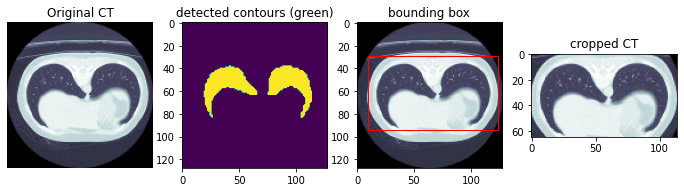

In [8]:
import random

idx = random.choice(range(len(cts)))
with tf.device('/cpu:0') :
    img = np.asarray(cts[idx, :, :, 0])
    bimg = np.asarray(pred_lungs[idx, :, :, 0])
    bounds = make_lungmask_bbox(img, bimg, display_flag=True)

In [50]:
ccts = []
clungs = []
cinfects = []
bad_ids = []

with tf.device('/cpu:0') :
    for ii in range(len(cts)) :
        try :
            ct_img = np.asarray(cts[ii, :, :, 0])
            lung_img = np.asarray(pred_lungs[ii, :, :, 0])
            infect_img = np.asarray(infects[ii, :, :, 0])

            bounds = make_lungmask_bbox(ct_img, lung_img, display_flag=False)

            cct_img = crop_(ct_img, bounds)
            img = cv.resize(cct_img, dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
            img = np.reshape(img, (img_size, img_size, 1))
            ccts.append(img)

            clung_img = crop_(lung_img.astype('float32'), bounds)
            img = cv.resize(clung_img, dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
            img = np.reshape(img, (img_size, img_size, 1))
            clungs.append(img)

            cinfect_img = crop_(infect_img.astype('float32'), bounds)
            img = cv.resize(cinfect_img, dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
            img = np.reshape(img, (img_size, img_size, 1))
            cinfects.append(img)
        except :
            bad_ids.append(ii)
 
print(len(ccts), len(clungs), len(cinfects), len(bad_ids))

4042 4042 4042 766


# 4. Visualizing Outputs

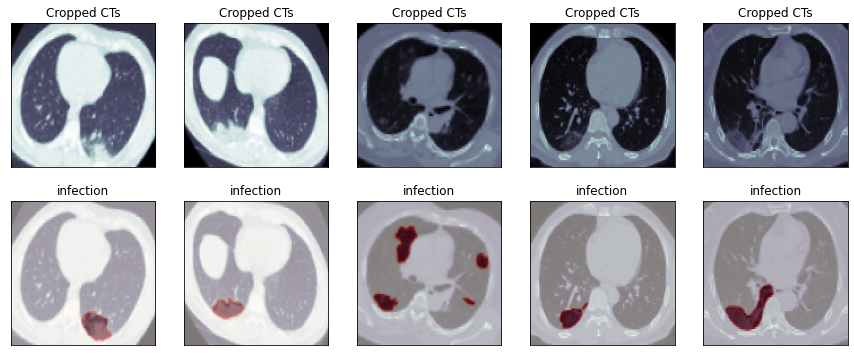

In [12]:
def plot_cts_masked(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('Cropped CTs')
    axes[0].set_xticks([]); axes[0].set_yticks([])
    
    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='Reds')
    axes[1].set_title('infection')
    axes[1].set_xticks([]); axes[1].set_yticks([])  

fig, axes = plt.subplots(2, 5, figsize=(15,6))

indices = random.choices(range(len(ccts)), k=5)
for ii, idx in enumerate(indices) :
    plot_cts_masked(ccts[idx], cinfects[idx], list(axes[:,ii]))

# 5. Processing and Saving

In [51]:
with tf.device('/cpu:0') :
    ccts = tf.convert_to_tensor(np.asarray(ccts))
    clungs = tf.convert_to_tensor(np.asarray(clungs))
    cinfects = tf.convert_to_tensor(np.asarray(cinfects))

print(ccts.shape, clungs.shape, cinfects.shape)

(4042, 128, 128, 1) (4042, 128, 128, 1) (4042, 128, 128, 1)


In [52]:
with open('../outputs/cropped_data.cp', 'wb') as myfile : 
    pickle.dump({'ccts': ccts, 'clungs': clungs, 'cinfects': cinfects}, myfile)